In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
d = pd.read_csv('marketing_campaign.csv')

In [27]:
variables = ['Income', 'MntWines', 'MntFruits',
            'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
            'MntGoldProds', 'NumDealsPurchases', 
            'MntTotal']

Строим корреляционную матрицу для выбранных в variables столбцов:

<AxesSubplot:>

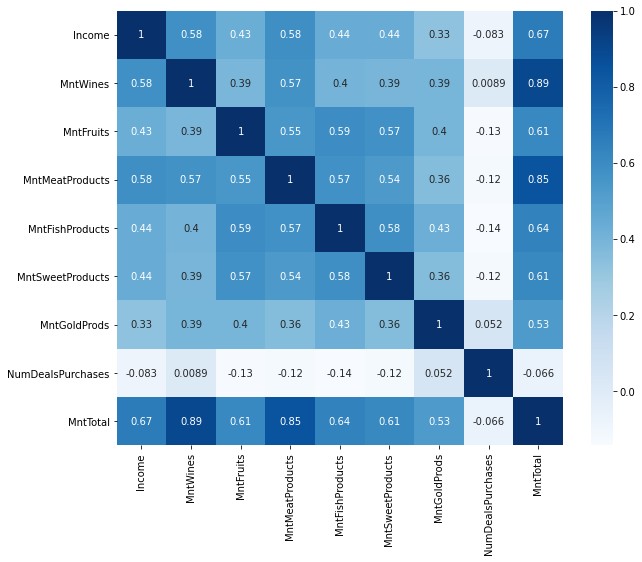

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(d[variables].corr(), annot=True, cmap='Blues')

Можем увидеть сильную положительную корреляцию между переменными:
- 'MntTotal' и 'MntWines'
- 'MntTotal' и 'MntMeatProducts'

'NumDealsPurchases' очень слабо коррелирует со всеми остальными переменными

Теперь необходимо стандартизировать данные. Так как единицы иизмерения переменных отличаются, нам необходимо пименять функцию стандартизации (сделать среднее значение = 0 и масштабировать данные до единичной дисперсии, чтобы данные находились в одном диапазоне значений).


В чем идея: например, значения 'MntWines' варьируются от 0 до 1493, а значения 'MntFruits' всего до 199. Но  функция в kmeans основана на вычислении расстояния, а значит придаст больший вес переменным 'MntWines' с большими значениями (чего мы не хотим допускать), если мы не стандартизуем данные. 

С помощью класса StandardScaler и функции fit_transform() стандартизируем выбранные в variables данные:

In [32]:
scaler = StandardScaler()
features = scaler.fit_transform(d[variables])

In [33]:
sse = []

for k in range(1, 15):
    # Создаем экземпляр класса KMeans иизадаем количество кластеров, равное итерационной переменной k
    kmeans = KMeans(n_clusters=k)
    # Запустим алгоритм k-means на наших стандартизированных данных
    kmeans.fit(features)
    # В массив sse кладем наименьшее значение суммы квадратов ошибок
    sse.append(kmeans.inertia_)

Строим график для всех полученных результатов с помощью библиотеки matplolib и функции plot():

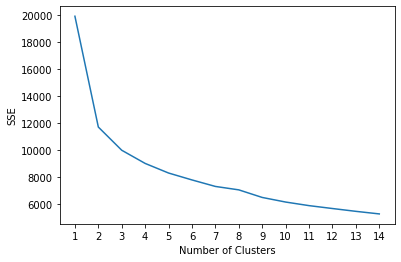

In [34]:
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

Мы видим, что с увеличением количества кластеров уменьшается сумма квадратов ошибок.

Выбираем количество кластеров, равное 3 (выбираем это количество по методу локтя: момент, когда сумма квадратов ошибок перестает существенно уменьшаться на графике), и запускаем алгоритм снова:

In [35]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(features)
sse.append(kmeans.inertia_)

Создаем новый столбец 'cluster' и кладем в него назначения кластеров:

In [36]:
d['cluster'] = kmeans.labels_

Для каждой переменной из variables считаем среднее значение и медиану, сгруппировав их по кластерам:

In [37]:
d.groupby('cluster').agg({v: ['mean', 'median'] for v in variables})

Income             MntWines         MntFruits         \
                 mean   median        mean median       mean median   
cluster                                                               
0        36512.141959  35797.0   58.527403   25.0   5.871518      3   
1        76836.346290  76110.5  615.095406  557.5  72.749117     62   
2        58943.245810  59235.0  489.381750  444.0  19.914339     13   

        MntMeatProducts        MntFishProducts        MntSweetProducts         \
                   mean median            mean median             mean median   
cluster                                                                         
0             26.965858     16        8.522911      4         5.831986      3   
1            452.473498    420      103.710247     94        74.669611     63   
2            156.331471    128       28.340782     17        20.748603     13   

        MntGoldProds        NumDealsPurchases            MntTotal          
                mean median              mean median         mean  median  
cluster                                                                    
0          15.652291   10.0          1.969452      2   121.371968    69.0  
1          79.477032   58.5          1.369258      1  1398.174912  1375.5  
2          65.217877   44.0          4.063315      4   779.934823   733.0

Кластеры сформированы по уровню дохода покупателей (можно заметить по показателям для 'Income'), разница в доходах очень заметная, так как разброс средних значений и медиан по кластерам сильный.


Первый кластер состоит из более состоятельных покупателей, которые совершали больше всего покупок: в этом кластере самые высокие показатели 'Income', самые низкие показатели для 'NumDealsPurchases' и в целом самые высокие затраты на различные категории продуктов. 